In [1]:
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import pandas as pd
df = pd.read_csv('medical_tc_train.csv')
df_test = pd.read_csv('medical_tc_test.csv')
print(df.shape)
print(df.head())


(11550, 2)
   label                                               text
0      5  Tissue changes around loose prostheses. A cani...
1      1  Neuropeptide Y and neuron-specific enolase lev...
2      2  Sexually transmitted diseases of the colon, re...
3      1  Lipolytic factors associated with murine and h...
4      3  Does carotid restenosis predict an increased r...


In [3]:
print(df_test.shape)
print(df_test.head())

(2888, 2)
   label                                               text
0      3  Obstructive sleep apnea following topical orop...
1      5  Neutrophil function and pyogenic infections in...
2      5  A phase II study of combined methotrexate and ...
3      1  Flow cytometric DNA analysis of parathyroid tu...
4      4  Paraneoplastic vasculitic neuropathy: a treata...


In [4]:
df.isna().sum()

,0
label,0
text,0


In [5]:
df_test.isna().sum()

,0
label,0
text,0


In [6]:
print("Classes:", df['label'].unique())

Classes: [5 1 2 3 4]


In [7]:
print("Classes:", df_test['label'].unique())

Classes: [3 5 1 4 2]


In [8]:
df['label'].value_counts()

,count
label,
5,3844
1,2530
4,2441
3,1540
2,1195


In [9]:
df_test['label'].value_counts()

,count
label,
5,961
1,633
4,610
3,385
2,299


In [10]:
df = df[df["text"].str.strip() != ""]  # remove empty strings
df_test = df_test[df_test["text"].str.strip() != ""]  # remove empty strings
# Split the dataset
X_train_texts, X_test_texts=df["text"],df_test["text"]
y_train, y_test=df["label"],df_test["label"]
y_train = y_train - 1
y_test = y_test - 1

# **Pipeline A: TF-IDF + Classifier (Baseline)**

In [24]:
vectorizer = TfidfVectorizer(
    max_features=5000,   # limit to top 5000 words (prevents overfitting)
    ngram_range=(1, 2),  # include unigrams + bigrams
    stop_words='english' # remove common English words
)
X_train = vectorizer.fit_transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predA = clf.predict(X_test)
acc = accuracy_score(y_test, y_predA)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predA))


Accuracy: 0.599376731301939

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72       633
           1       0.48      0.70      0.57       299
           2       0.51      0.68      0.58       385
           3       0.67      0.74      0.70       610
           4       0.57      0.34      0.43       961

    accuracy                           0.60      2888
   macro avg       0.59      0.64      0.60      2888
weighted avg       0.60      0.60      0.59      2888



In [12]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((11550, 5000), (11550,), (2888, 5000), (2888,))

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_size = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_size,)),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │     5,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,126,149 (19.55 MB)

 Trainable params: 5,126,149 (19.55 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=1024)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3208 - loss: 1.5493 - val_accuracy: 0.4082 - val_loss: 1.3648
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4853 - loss: 1.2837 - val_accuracy: 0.5374 - val_loss: 1.1562
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5974 - loss: 1.0540 - val_accuracy: 0.5699 - val_loss: 1.0265
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6483 - loss: 0.8946 - val_accuracy: 0.5886 - val_loss: 0.9754
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6801 - loss: 0.8026 - val_accuracy: 0.5921 - val_loss: 0.9655


In [27]:
y_predA = model.predict(X_test)
y_predA.shape

91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step


(2888, 5)

In [28]:
y_predA=np.argmax(y_predA,axis=1)
y_predA.shape
acc = accuracy_score(y_test, y_predA)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predA))

Accuracy: 0.5921052631578947

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       633
           1       0.55      0.49      0.52       299
           2       0.59      0.50      0.54       385
           3       0.65      0.68      0.66       610
           4       0.50      0.52      0.51       961

    accuracy                           0.59      2888
   macro avg       0.60      0.58      0.59      2888
weighted avg       0.59      0.59      0.59      2888



# **Pipeline B: Word2Vec + Classifier (Semantic Baseline)**

In [30]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.9 MB/s eta 0:00:00


In [31]:
# Very Bad because it doesn't know that a single word change full sentence meaning like "not" and OOV problem that it doesn't know what to do with it
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm

# simple_preprocess handles lowercasing and basic cleaning
sentences = [simple_preprocess(str(text)) for text in X_train_texts]
import multiprocessing
num_cores = multiprocessing.cpu_count()
#Embedding model
w2v_model = Word2Vec(
    vector_size=300,
    window=5,
    min_count=2,
    sg=1,
    workers=num_cores
)

w2v_model.build_vocab(sentences)
w2v_model.train(
    corpus_iterable=sentences,
    total_examples=w2v_model.corpus_count,
    epochs=40
)

def get_w2v_embedding(text, model, vector_size=300):
    """Return averaged Word2Vec embedding for a given text."""
    words = word_tokenize(text.lower())
    valid_words = [w for w in words if w in model.wv]
    if not valid_words:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_words], axis=0)


In [32]:
print(len(sentences))           # should match df rows
print(sum(len(s) for s in sentences))  # total number of tokens; must be > 0


11550
1943741


In [33]:
print("Vocabulary size:", len(w2v_model.wv))
print("Example vector:", w2v_model.wv['diseases'][:10])


Vocabulary size: 23598
Example vector: [-0.00068371  0.19418362 -0.10004063  0.08062191 -0.07072804  0.01213332
 -0.02204221 -0.12990037  0.1998624   0.04341627]


In [34]:
w2v_model.wv.most_similar('diseases', topn=5)


[('stds', 0.43040764331817627),
 ('pimas', 0.39186009764671326),
 ('disease', 0.38095739483833313),
 ('concurrence', 0.3509458303451538),
 ('diarrhoeal', 0.34319910407066345)]

In [35]:
vec = get_w2v_embedding("the cancer is growing fast", w2v_model)
print(vec.shape)  # should be (300,)


(300,)


In [36]:
# Very Bad because it doesn't know that a single word change full sentence meaning like "not"
X_train = np.vstack([get_w2v_embedding(t, w2v_model) for t in tqdm(X_train_texts)])
X_test  = np.vstack([get_w2v_embedding(t, w2v_model) for t in tqdm(X_test_texts)])
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predB = clf.predict(X_test)
acc = accuracy_score(y_test, y_predB)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predB))

100%|██████████| 2888/2888 [00:11<00:00, 258.52it/s]


Accuracy: 0.6007617728531855

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74       633
           1       0.47      0.75      0.58       299
           2       0.52      0.71      0.60       385
           3       0.64      0.79      0.71       610
           4       0.61      0.27      0.38       961

    accuracy                           0.60      2888
   macro avg       0.59      0.66      0.60      2888
weighted avg       0.61      0.60      0.58      2888



In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_size = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_size,)),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 5)              │         1,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 1,505 (5.88 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=1024)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.2482 - loss: 1.5791 - val_accuracy: 0.3383 - val_loss: 1.5276
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3358 - loss: 1.5175 - val_accuracy: 0.3338 - val_loss: 1.4950
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3354 - loss: 1.4880 - val_accuracy: 0.3338 - val_loss: 1.4774
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3333 - loss: 1.4736 - val_accuracy: 0.3376 - val_loss: 1.4604
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3477 - loss: 1.4503 - val_accuracy: 0.3566 - val_loss: 1.4439
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3666 - loss: 1.4352 - val_accuracy: 0.3684 - val_loss: 1.4281
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3834 - loss: 1.4194 - val_accuracy: 0.3902 - val_loss: 1.4128
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4032 - loss: 1.4053 - val_accuracy: 0.4086 -

In [39]:
y_predB = model.predict(X_test)
y_predB=np.argmax(y_predB,axis=1)
y_predB.shape
acc = accuracy_score(y_test, y_predB)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predB))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.5934903047091413

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72       633
           1       0.55      0.41      0.47       299
           2       0.64      0.43      0.51       385
           3       0.65      0.71      0.68       610
           4       0.49      0.55      0.52       961

    accuracy                           0.59      2888
   macro avg       0.61      0.57      0.58      2888
weighted avg       0.60      0.59      0.59      2888



# **Pipeline C: Pre-trained Transformer Embedder + Classifier**

In [11]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [12]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

def clean_texts(texts):
    """
    Ensures all items are strings and removes NaNs or None.
    """
    # Convert to pandas Series for easy cleaning
    s = pd.Series(texts).dropna().astype(str)
    return s.tolist()

def get_embeddings_batch(texts, batch_size=16, pooling="cls", max_length=256):
    texts = clean_texts(texts)
    all_embeddings = []

    if torch.cuda.is_available():
        model.to("cuda")

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length
        )

        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            if pooling == "mean":
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            else:
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)


In [13]:
# Using CLS token embedding
X_train = get_embeddings_batch(X_train_texts, batch_size=128)
X_test = get_embeddings_batch(X_test_texts, batch_size=128)
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Accuracy: 0.5858725761772853

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72       633
           1       0.46      0.70      0.55       299
           2       0.52      0.66      0.58       385
           3       0.63      0.76      0.69       610
           4       0.56      0.30      0.39       961

    accuracy                           0.59      2888
   macro avg       0.57      0.63      0.59      2888
weighted avg       0.59      0.59      0.57      2888



In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
input_size = X_train.shape[1]

clf = models.Sequential([
    layers.Input(shape=(input_size,)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

clf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
clf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         3,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
clf.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=1024)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.2450 - loss: 1.8489 - val_accuracy: 0.4062 - val_loss: 1.3754
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3812 - loss: 1.5002 - val_accuracy: 0.5194 - val_loss: 1.1758
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4559 - loss: 1.2996 - val_accuracy: 0.5544 - val_loss: 1.0709
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5020 - loss: 1.1863 - val_accuracy: 0.5731 - val_loss: 1.0132
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5429 - loss: 1.1087 - val_accuracy: 0.5855 - val_loss: 0.9797
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5565 - loss: 1.0739 - val_accuracy: 0.5928 - val_loss: 0.9589
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5642 - loss: 1.0502 - val_accuracy: 0.6011 - val_loss: 0.9435
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5685 - loss: 1.0291 - val_accuracy: 0.6028 

In [16]:
y_pred = clf.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.6142659279778393

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.74       633
           1       0.55      0.52      0.53       299
           2       0.61      0.52      0.56       385
           3       0.66      0.74      0.70       610
           4       0.52      0.49      0.51       961

    accuracy                           0.61      2888
   macro avg       0.61      0.61      0.61      2888
weighted avg       0.61      0.61      0.61      2888



In [17]:
# Using mean pooling embedding
X_train = get_embeddings_batch(X_train_texts, batch_size=128,pooling="mean")
X_test = get_embeddings_batch(X_test_texts, batch_size=128,pooling="mean")
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predC = clf.predict(X_test)
acc = accuracy_score(y_test, y_predC)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Accuracy: 0.5772160664819944

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.74       633
           1       0.55      0.52      0.53       299
           2       0.61      0.52      0.56       385
           3       0.66      0.74      0.70       610
           4       0.52      0.49      0.51       961

    accuracy                           0.61      2888
   macro avg       0.61      0.61      0.61      2888
weighted avg       0.61      0.61      0.61      2888



In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
input_size = X_train.shape[1]

clf = models.Sequential([
    layers.Input(shape=(input_size,)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

clf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
clf.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         3,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
clf.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=1024)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.2298 - loss: 1.9938 - val_accuracy: 0.3961 - val_loss: 1.4174
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3658 - loss: 1.5777 - val_accuracy: 0.4778 - val_loss: 1.2331
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4369 - loss: 1.3707 - val_accuracy: 0.5429 - val_loss: 1.1223
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4885 - loss: 1.2389 - val_accuracy: 0.5571 - val_loss: 1.0519
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5179 - loss: 1.1592 - val_accuracy: 0.5744 - val_loss: 1.0120
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5455 - loss: 1.0959 - val_accuracy: 0.5814 - val_loss: 0.9825
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5522 - loss: 1.0694 - val_accuracy: 0.5845 - val_loss: 0.9635
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5782 - loss: 1.0248 - val_accuracy: 0.5931 -

In [23]:
y_predC = clf.predict(X_test)
y_predC=np.argmax(y_predC,axis=1)
acc = accuracy_score(y_test, y_predC)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.6187673130193906

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.74       633
           1       0.55      0.52      0.53       299
           2       0.61      0.52      0.56       385
           3       0.66      0.74      0.70       610
           4       0.52      0.49      0.51       961

    accuracy                           0.61      2888
   macro avg       0.61      0.61      0.61      2888
weighted avg       0.61      0.61      0.61      2888



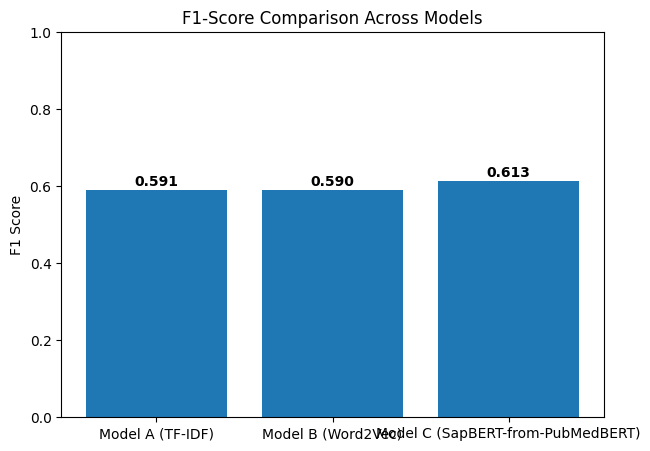

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Compute F1-scores
f1_A = f1_score(y_test, y_predA, average='weighted')
f1_B = f1_score(y_test, y_predB, average='weighted')
f1_C = f1_score(y_test, y_predC, average='weighted')

# Prepare data
models = ['Model A (TF-IDF)', 'Model B (Word2Vec)', 'Model C (SapBERT-from-PubMedBERT)']
f1_scores = [f1_A, f1_B, f1_C]

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(models, f1_scores)

# Add values on top of bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.3f}", ha='center', fontsize=10, weight='bold')

plt.ylabel("F1 Score")
plt.title("F1-Score Comparison Across Models")
plt.ylim(0, 1)
plt.show()
